In [1]:
path = "../input/scene_classification/scene_classification/train/"

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
bs = 256

In [4]:
df = pd.read_csv('../input/scene_classification/scene_classification/train.csv')
df.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [5]:
df_sub = df[(df['label'] != 2) & (df['label'] != 5)]
df_sub['label'].value_counts()

3    3037
4    2784
1    2745
0    2628
Name: label, dtype: int64

In [6]:
tfms = get_transforms(flip_vert=False,max_zoom=1.0,max_warp=0)

In [7]:
allClasses = [0,1,2,3,4,5]

In [8]:
data_small_sub = (ImageList.from_df(df_sub,path) 
        .split_by_rand_pct()              
        .label_from_df(classes=allClasses)            
        .add_test_folder(test_folder = '../test')              
        .transform(tfms, size=128)
        .databunch(num_workers=0))

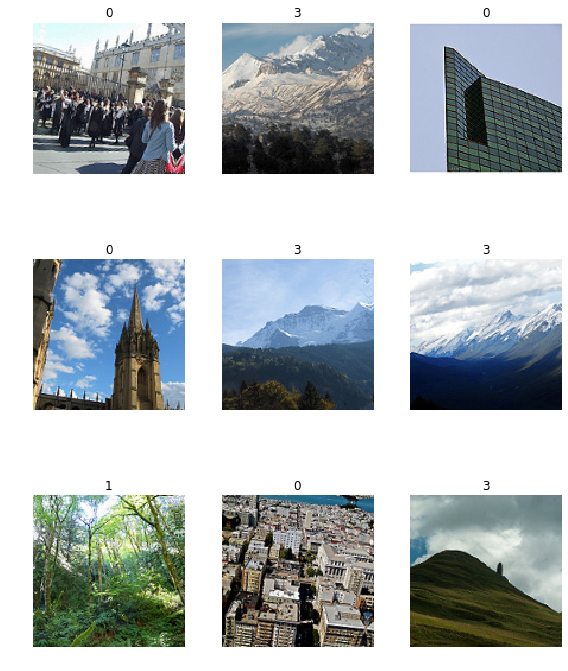

In [9]:
data_small_sub.show_batch(rows=3, figsize=(8,10))

In [10]:
data_large_full = (ImageList.from_df(df,path) 
        .split_by_rand_pct()              
        .label_from_df(classes=allClasses)            
        .add_test_folder(test_folder = '../test')              
        .transform(tfms, size=256)
        .databunch(num_workers=0))

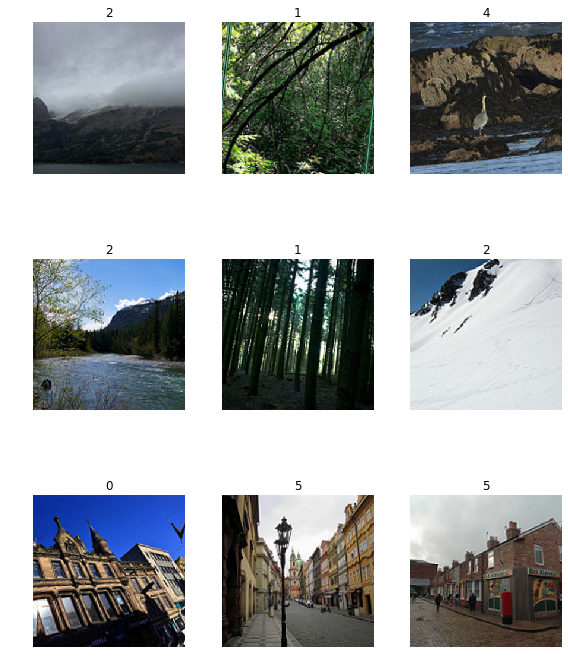

In [11]:
data_large_full.show_batch(rows=3, figsize=(8,10))

In [12]:
print(data_small_sub.classes)
print(data_large_full.classes)

[0, 1, 2, 3, 4, 5]
[0, 1, 2, 3, 4, 5]


In [13]:
learn_101 = cnn_learner(data_small_sub, models.resnet101, metrics=[error_rate, accuracy], model_dir="/tmp/model/")

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /tmp/.torch/models/resnet101-5d3b4d8f.pth
178728960it [00:01, 92397231.23it/s]


In [14]:
learn_101.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.215061,0.109231,0.039768,0.960232,01:19
1,0.111845,0.064809,0.022341,0.977659,00:58
2,0.068300,0.057035,0.019660,0.980340,00:59
3,0.049805,0.057329,0.018320,0.981680,00:58


In [15]:
interp = ClassificationInterpretation.from_learner(learn_101)

losses,idxs = interp.top_losses()

len(data_small_sub.valid_ds)==len(losses)==len(idxs)

True

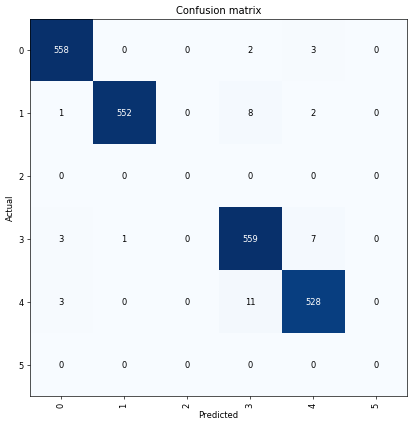

In [16]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=60)

In [17]:
learn_101.save('/kaggle/working/resnet101-size128-fewclasses-stage1')

In [18]:
learn_101.data = data_large_full

In [19]:
learn_101.unfreeze()

In [20]:
learn_101.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


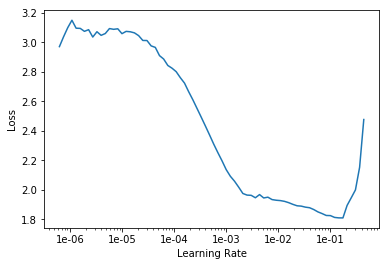

In [21]:
learn_101.recorder.plot()

In [22]:
learn_101.fit_one_cycle(2, max_lr=slice(1e-5, 1e-4))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.385566,0.215971,0.067234,0.932766,04:25
1,0.193870,0.190079,0.061950,0.938051,04:16


In [23]:
learn_101.save('/kaggle/working/resnet101-size256-allclasses-stage1')

In [24]:
interp = ClassificationInterpretation.from_learner(learn_101)

losses,idxs = interp.top_losses()

len(data_large_full.valid_ds)==len(losses)==len(idxs)

True

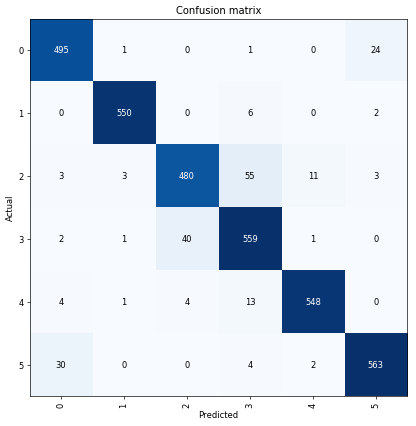

In [25]:
interp.plot_confusion_matrix(figsize=(7,7), dpi=60)